## ConvNN Attention Edition

In [1]:

import torch 
import torch.nn as nn
from torch.nn import Conv1d
import torch.nn.functional as F 

import numpy as np

# Train + Data 
import sys 
sys.path.append('../Layers')
from pixelshuffle import PixelShuffle1D, PixelUnshuffle1D


#### i. KNN ViT

In [2]:
x = torch.randn(32, 3, 64)
qkv = nn.Linear(64, 64 * 3, bias=False)
num_heads = 1

B, C, N = x.shape
qkv = qkv(x).reshape(B, N, 3, num_heads, C // num_heads).permute(2, 0, 3, 1, 4)
q, k, v = qkv[0], qkv[1], qkv[2]   # make torchscript happy (cannot use tensor as tuple)
attn = (q @ k.transpose(-2, -1)) 

In [3]:
print('Attention shape:', attn.shape)
print("qkv:", qkv.shape)
print("q:", q.shape)
print("k:", k.shape)
print("v:", v.shape)


Attention shape: torch.Size([32, 1, 64, 64])
qkv: torch.Size([3, 32, 1, 64, 3])
q: torch.Size([32, 1, 64, 3])
k: torch.Size([32, 1, 64, 3])
v: torch.Size([32, 1, 64, 3])


## ii. ConvNN Attn 

In [4]:
x = torch.randn(32, 3, 64)
w_q = nn.Linear(64, 64, bias=False)
w_k = nn.Linear(64, 64, bias=False)
w_v = nn.Linear(64, 64, bias=False)

q = w_q(x)
k = w_k(x)
v = w_v(x)

attn = (k.transpose(-2, -1) @ q) 

print('Attention shape:', attn.shape)
print("q:", q.shape)
print("k:", k.shape)
print("v:", v.shape)

Attention shape: torch.Size([32, 64, 64])
q: torch.Size([32, 3, 64])
k: torch.Size([32, 3, 64])
v: torch.Size([32, 3, 64])


### 1. Matrix Calcuations

Distance matrix calculation

In [5]:

def _calculate_distance_matrix_alt(K, Q, sqrt=False):
    """
    Calculate the distance matrix between two sets of vectors.
    
    Args:
        K (torch.Tensor): The first set of vectors (shape: [B, C, N]).
        Q (torch.Tensor): The second set of vectors (shape: [B, C, M]).
        sqrt (bool): If True, return the square root of the distance matrix.
        
    Returns:
        torch.Tensor: The distance matrix (shape: [B, N, M]).
    """
    # For [B, C, N] and [B, C, M] format
    norm_squared_K = torch.sum(K**2, dim=1, keepdim=True)  # [B, 1, N]
    norm_squared_Q = torch.sum(Q**2, dim=1, keepdim=True)  # [B, 1, M]
    
    dot_product = torch.bmm(K.transpose(2, 1), Q)  # [B, N, M]
    
    # Broadcasting: [B, 1, N] + [B, M, 1] - 2*[B, N, M]
    dist_matrix = norm_squared_K + norm_squared_Q.transpose(2, 1) - 2 * dot_product
    
    dist_matrix = torch.clamp(dist_matrix, min=0)  # remove negative values
    
    if sqrt:
        dist_matrix = torch.sqrt(dist_matrix)
    
    return dist_matrix


def _calculate_distance_matrix_alt_2(K, Q, sqrt=False):
    """
    Calculate the distance matrix between two sets of vectors.
    
    Args:
        K (torch.Tensor): The first set of vectors (shape: [B, C, N]).
        Q (torch.Tensor): The second set of vectors (shape: [B, C, M]).
        sqrt (bool): If True, return the square root of the distance matrix.
        
    Returns:
        torch.Tensor: The distance matrix (shape: [B, N, M]).
    """
    # For [B, C, N] and [B, C, M] format
    norm_squared_K = torch.sum(K**2, dim=1, keepdim=True)  # [B, 1, N]
    norm_squared_Q = torch.sum(Q**2, dim=1, keepdim=True)  # [B, 1, M]
    
    dot_product = torch.bmm(K.transpose(1, 2), Q)  # [B, N, M]
    
    # Broadcasting: [B, 1, N] + [B, M, 1] - 2*[B, N, M]
    dist_matrix = norm_squared_K + norm_squared_Q.transpose(1, 2) - 2 * dot_product
    
    dist_matrix = torch.clamp(dist_matrix, min=0)  # remove negative values
    
    if sqrt:
        dist_matrix = torch.sqrt(dist_matrix)
    
    return dist_matrix

In [6]:
d = _calculate_distance_matrix_alt(k, q)
print('Distance matrix shape:', d.shape)
d1 = _calculate_distance_matrix_alt_2(k, q)
print('Distance matrix 2 shape:', d1.shape)

# Note: Distance and similarity matrices are inherently different
# To compare them, you need a transformation:
print('Are they similar?', torch.allclose(d, d1, rtol=1e-2, atol=1e-2))

Distance matrix shape: torch.Size([32, 64, 64])
Distance matrix 2 shape: torch.Size([32, 64, 64])
Are they similar? True


similarity matrix calculation

In [7]:
def _calculate_similarity_matrix_alt(k, q):
    k_norm = F.normalize(k, p=2, dim=1)
    q_norm = F.normalize(q, p=2, dim=1)
    similarity_matrix = torch.bmm(k_norm.transpose(2, 1), q_norm)  # [B, N, M]
    similarity_matrix = torch.clamp(similarity_matrix, min=0)  # remove negative values
    return similarity_matrix



def _calculate_similarity_matrix_alt_1(k, q):
    k_norm = F.normalize(k, p=2, dim=1)
    q_norm = F.normalize(q, p=2, dim=1)
    similarity_matrix = torch.bmm(k_norm.transpose(1, 2), q_norm)  # [B, N, M]
    similarity_matrix = torch.clamp(similarity_matrix, min=0)  # remove negative values
    return similarity_matrix

s = _calculate_similarity_matrix_alt(k, q)
print('Similarity matrix shape:', s.shape)
s1 = _calculate_similarity_matrix_alt_1(k, q)
print('Similarity matrix 2 shape:', s1.shape)
# Note: Distance and similarity matrices are inherently different
# To compare them, you need a transformation:
print('Are they similar?', torch.allclose(s, s1, rtol=1e-2, atol=1e-2))

Similarity matrix shape: torch.Size([32, 64, 64])
Similarity matrix 2 shape: torch.Size([32, 64, 64])
Are they similar? True


In [8]:
#### FINAL FUNCTIONS
def _calculate_similarity_matrix(k, q):
    k_norm = F.normalize(k, p=2, dim=1)
    q_norm = F.normalize(q, p=2, dim=1)
    similarity_matrix = torch.bmm(k_norm.transpose(2, 1), q_norm)  # [B, N, M]
    similarity_matrix = torch.clamp(similarity_matrix, min=0)  # remove negative values
    return similarity_matrix

def _calculate_distance_matrix(K, Q, sqrt=False):
    norm_squared_K = torch.sum(K**2, dim=1, keepdim=True) 
    norm_squared_Q = torch.sum(Q**2, dim=1, keepdim=True) 
    
    dot_product = torch.bmm(K.transpose(2, 1), Q)  
    
    # Broadcasting: [B, 1, N] + [B, M, 1] - 2*[B, N, M]
    dist_matrix = norm_squared_K + norm_squared_Q.transpose(2, 1) - 2 * dot_product
    
    dist_matrix = torch.clamp(dist_matrix, min=0)  # remove negative values
    
    if sqrt:
        dist_matrix = torch.sqrt(dist_matrix)
    
    return dist_matrix

### 2. Matrix Multiplication N samples

In [9]:
def _calculate_similarity_matrix_N(k, q):
    k_norm = F.normalize(k, p=2, dim=1)
    q_norm = F.Normalize(q, p=2, dim=1)
    similarity_matrix = torch.bmm(k_norm.transpose(1, 2), q_norm)  # [B, N, M]
    similarity_matrix = torch.clamp(similarity_matrix, min=0)  # remove negative values
    return similarity_matrix

def _calculate_distance_matrix_N(K, Q, sqrt=False):
    norm_squared_K = torch.sum(K**2, dim=1, keepdim=True).permute(0, 2, 1)
    norm_squared_Q = torch.sum(Q**2, dim=1, keepdim=True).transpose(2, 1).permute(0, 2, 1)
    
    dot_product = torch.bmm(K.transpose(2, 1), Q)  
    
    # Broadcasting: [B, 1, N] + [B, M, 1] - 2*[B, N, M]
    dist_matrix = norm_squared_K + norm_squared_Q - 2 * dot_product
    
    dist_matrix = torch.clamp(dist_matrix, min=0)  # remove negative values
    
    if sqrt:
        dist_matrix = torch.sqrt(dist_matrix)
    
    return dist_matrix


### 3. Prime + Prime N 

In [10]:
def _prime(v, qk, K, maximum):
    b, c, t = v.shape 
    
    _, topk_indices = torch.topk(qk, k=K, dim=-1, largest = maximum)
    
    topk_indices_exp = topk_indices.unsqueeze(1).expand(b, c, t, K)
    
    v_expanded = v.unsqueeze(-1).expand(b, c, t, K)
    
    prime = torch.gather(v_expanded, dim=2, index=topk_indices_exp)
    
    prime = prime.reshape(b, c, -1)

    return prime

In [11]:
    
def _prime_N(v, qk, K, rand_idx, maximum):
    b, c, t = v.shape

    # Get top-(K-1) indices from the magnitude matrix; shape: [b, t, K-1]
    _, topk_indices = torch.topk(qk, k=K - 1, dim=2, largest=maximum)
    tk = topk_indices.shape[-1]
    assert K == tk + 1, "Error: K must be same as tk + 1. K == tk + 1."

    # Map indices from the sampled space to the full token indices using rand_idx.
    # mapped_tensor will have shape: [b, t, K-1]
    mapped_tensor = rand_idx[topk_indices]

    # Create self indices for each token; shape: [1, t, 1] then expand to [b, t, 1]
    token_indices = torch.arange(t, device=v.device).view(1, t, 1).expand(b, t, 1)

    # Concatenate self index with neighbor indices to form final indices; shape: [b, t, K]
    final_indices = torch.cat([token_indices, mapped_tensor], dim=2)

    # Expand final_indices to include the channel dimension; result shape: [b, c, t, K]
    indices_expanded = final_indices.unsqueeze(1).expand(b, c, t, K)

    # Expand matrix to shape [b, c, t, 1] and then to [b, c, t, K] (ensuring contiguous memory)
    v_expanded = v.unsqueeze(-1).expand(b, c, t, K).contiguous()

    # Gather neighbor features along the token dimension (dim=2)
    prime = torch.gather(v_expanded, dim=2, index=indices_expanded)  # shape: [b, c, t, K]

    # Flatten the token and neighbor dimensions into one: [b, c, t*K]
    prime = prime.reshape(b, c, -1)
    return prime

In [12]:
ex = torch.randn(32, 3, 32)
ex1 = torch.randn(32, 32, 32)
prime = _prime(ex, ex1, 3, True)
print('Prime shape:', prime.shape)
prime1 = _prime_N(ex, ex1, 3, torch.arange(32), True)
print('Prime 1 shape:', prime1.shape)
print('Are they similar?', torch.allclose(prime, prime1, rtol=1e-2, atol=1e-2))

Prime shape: torch.Size([32, 3, 96])
Prime 1 shape: torch.Size([32, 3, 96])
Are they similar? False


### Full Code

In [13]:
'''Convolution 1D Nearest Neighbors Attention Layer'''

'''
Conv1d_NN_Attn is a variation of Conv1d_NN that incorporates the attention mechanism. 
'''

import torch 
import torch.nn as nn
from torch.nn import Conv1d
import torch.nn.functional as F 
import numpy as np 


class Conv1d_NN_Attn(nn.Module):
    """
    Convolutional 1D Nearest Neighbors Attention Layer 
    """
    
    def __init__(self, 
                in_channels, 
                out_channels, 
                K=3, 
                stride=3, 
                padding=0, 
                shuffle_pattern='N/A', 
                shuffle_scale=2, 
                samples='all', 
                magnitude_type='similarity', 
                num_tokens=224, 
                ): 
        
        """
        Initializes the Conv1d_NN module.
        
        Parameters:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            K (int): Number of Nearest Neighbors for consideration.
            stride (int): Stride size.
            padding (int): Padding size.
            shuffle_pattern (str): Shuffle pattern: "B", "A", "BA".
            shuffle_scale (int): Shuffle scale factor.
            samples (int/str): Number of samples to consider.
            magnitude_type (str): Distance or Similarity.
        """
        
        super(Conv1d_NN_Attn, self).__init__()
    
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.K = K
        self.stride = stride 
        self.padding = padding
        self.shuffle_pattern = shuffle_pattern 
        self.shuffle_scale = shuffle_scale
        self.samples = int(samples) if samples != 'all' else samples 
        self.magnitude_type = magnitude_type 
        self.maximum = True if self.magnitude_type == 'similarity' else False
        self.num_tokens = int(num_tokens / 2) if self.shuffle_pattern in ["B", "BA"] else num_tokens
        
        # Unshuffle layer 
        self.unshuffle_layer = PixelUnshuffle1D(downscale_factor=self.shuffle_scale)
        
        # Shuffle Layer 
        self.shuffle_layer = PixelShuffle1D(upscale_factor=self.shuffle_scale)
        
        # Channels for Conv1d Layer
        self.in_channels = in_channels * shuffle_scale if self.shuffle_pattern in ["BA", "B"] else in_channels
        self.out_channels = out_channels * shuffle_scale if self.shuffle_pattern in ["BA", "A"] else out_channels

        # Conv1d Layer 
        self.conv1d_layer = Conv1d(in_channels=self.in_channels, 
                                    out_channels=self.out_channels, 
                                    kernel_size=self.K, 
                                    stride=self.stride, 
                                    padding=self.padding)
        
        # Linear Layer for Query, Key, Value
        self.q = nn.Linear(self.num_tokens, self.num_tokens, bias=False)
        self.k = nn.Linear(self.num_tokens, self.num_tokens, bias=False)
        self.v = nn.Linear(self.num_tokens, self.num_tokens, bias=False)
                
        
    def forward(self, x): 
        # Consider all samples 
        if self.samples == 'all': 
            # Unshuffle Layer 
            if self.shuffle_pattern in ["B", "BA"]:
                x1 = self.unshuffle_layer(x)
            else:
                x1 = x
                
            # Q, K, V 
            q = self.q(x1)
            k = self.k(x1)
            v = self.v(x1)
            
            
            # Calculate Distance/Similarity Matrix + Prime Vmap 2D
            if self.magnitude_type == 'distance': 
                matrix_magnitude = self._calculate_distance_matrix(k, q, sqrt=True)
            elif self.magnitude_type == 'similarity':
                matrix_magnitude = self._calculate_similarity_matrix(k, q)
                
            prime_2d = self._prime(v, matrix_magnitude, self.K, self.maximum) 
            
            # Conv1d Layer
            x2 = self.conv1d_layer(prime_2d)
            
            
            # Shuffle Layer 
            if self.shuffle_pattern in ["A", "BA"]:
                x3 = self.shuffle_layer(x2)
            else:
                x3 = x2
            
            return x3
        
        # Consider N samples
        else: 
            # Unshuffle Layer 
            if self.shuffle_pattern in ["B", "BA"]:
                x1 = self.unshuffle_layer(x)
            else:
                x1 = x
                
            # Q, K, V
            q = self.q(x1)
            k = self.k(x1)
            v = self.v(x1)
                
            # Calculate Distance/Similarity Matrix + Prime       
            rand_idx = torch.randperm(x1.shape[2], device=x1.device)[:self.samples]
            
            q_sample = q[:, :, rand_idx]
            
            if self.magnitude_type == 'distance':
                matrix_magnitude = self._calculate_distance_matrix_N(k, q_sample, sqrt=True)
            elif self.magnitude_type == 'similarity':
                matrix_magnitude = self._calculate_similarity_matrix_N(k, q_sample)
                
            range_idx = torch.arange(len(rand_idx), device=x1.device)
                
        
            if self.magnitude_type == 'distance':
                matrix_magnitude[:, rand_idx, range_idx] = float('inf') 
            elif self.magnitude_type == 'similarity':
                matrix_magnitude[:, rand_idx, range_idx] = float('-inf')
                
            
            prime = self._prime_N(v, matrix_magnitude, self.K, rand_idx, self.maximum)
            
            # Conv1d Layer
            x2 = self.conv1d_layer(prime)
            
            # Shuffle Layer
            if self.shuffle_pattern in ["A", "BA"]:
                x3 = self.shuffle_layer(x2)
            else:
                x3 = x2
            
            return x3
        

    def _calculate_similarity_matrix(self, K, Q):
        k_norm = F.normalize(K, p=2, dim=1)
        q_norm = F.normalize(Q, p=2, dim=1)
        similarity_matrix = torch.bmm(k_norm.transpose(2, 1), q_norm)  # [B, N, M]
        similarity_matrix = torch.clamp(similarity_matrix, min=0)  # remove negative values
        return similarity_matrix
    
    def _calculate_similarity_matrix_N(self, K, Q):
        k_norm = F.normalize(K, p=2, dim=1)
        q_norm = F.normalize(Q, p=2, dim=1)
        similarity_matrix = torch.bmm(k_norm.transpose(2, 1), q_norm)  # [B, N, M]
        similarity_matrix = torch.clamp(similarity_matrix, min=0)  # remove negative values
        return similarity_matrix
        

    def _calculate_distance_matrix(self, K, Q, sqrt=False):
        norm_squared_K = torch.sum(K**2, dim=1, keepdim=True) 
        norm_squared_Q = torch.sum(Q**2, dim=1, keepdim=True) 
        
        dot_product = torch.bmm(K.transpose(2, 1), Q)  
        
        # Broadcasting: [B, 1, N] + [B, M, 1] - 2*[B, N, M]
        dist_matrix = norm_squared_K + norm_squared_Q.transpose(2, 1) - 2 * dot_product
        
        dist_matrix = torch.clamp(dist_matrix, min=0)  # remove negative values
        
        if sqrt:
            dist_matrix = torch.sqrt(dist_matrix)
        
        return dist_matrix

    def _calculate_distance_matrix_N(self, K, Q, sqrt=False):
        norm_squared_K = torch.sum(K**2, dim=1, keepdim=True).permute(0, 2, 1)
        norm_squared_Q = torch.sum(Q**2, dim=1, keepdim=True).transpose(2, 1).permute(0, 2, 1)
        
        dot_product = torch.bmm(K.transpose(2, 1), Q)  
        
        # Broadcasting: [B, 1, N] + [B, M, 1] - 2*[B, N, M]
        dist_matrix = norm_squared_K + norm_squared_Q - 2 * dot_product
        
        dist_matrix = torch.clamp(dist_matrix, min=0)  # remove negative values
        
        if sqrt:
            dist_matrix = torch.sqrt(dist_matrix)
        
        return dist_matrix

    def _prime(self, v, qk, K, maximum):
        b, c, t = v.shape 
        
        _, topk_indices = torch.topk(qk, k=K, dim=-1, largest = maximum)
        
        topk_indices_exp = topk_indices.unsqueeze(1).expand(b, c, t, K)
        
        v_expanded = v.unsqueeze(-1).expand(b, c, t, K)
        
        prime = torch.gather(v_expanded, dim=2, index=topk_indices_exp)
        
        prime = prime.reshape(b, c, -1)

        return prime
        
            
            
    def _prime_N(self, v, qk, K, rand_idx, maximum):
        b, c, t = v.shape

        # Get top-(K-1) indices from the magnitude matrix; shape: [b, t, K-1]
        _, topk_indices = torch.topk(qk, k=K - 1, dim=2, largest=maximum)
        tk = topk_indices.shape[-1]
        assert K == tk + 1, "Error: K must be same as tk + 1. K == tk + 1."

        # Map indices from the sampled space to the full token indices using rand_idx.
        # mapped_tensor will have shape: [b, t, K-1]
        mapped_tensor = rand_idx[topk_indices]

        # Create self indices for each token; shape: [1, t, 1] then expand to [b, t, 1]
        token_indices = torch.arange(t, device=v.device).view(1, t, 1).expand(b, t, 1)

        # Concatenate self index with neighbor indices to form final indices; shape: [b, t, K]
        final_indices = torch.cat([token_indices, mapped_tensor], dim=2)

        # Expand final_indices to include the channel dimension; result shape: [b, c, t, K]
        indices_expanded = final_indices.unsqueeze(1).expand(b, c, t, K)

        # Expand matrix to shape [b, c, t, 1] and then to [b, c, t, K] (ensuring contiguous memory)
        v_expanded = v.unsqueeze(-1).expand(b, c, t, K).contiguous()

        # Gather neighbor features along the token dimension (dim=2)
        prime = torch.gather(v_expanded, dim=2, index=indices_expanded)  # shape: [b, c, t, K]

        # Flatten the token and neighbor dimensions into one: [b, c, t*K]
        prime = prime.reshape(b, c, -1)
        return prime

### Testing

In [14]:
ex = torch.randn(32, 3, 32)

conv1d_NN_attn = Conv1d_NN_Attn(in_channels=3,
                                out_channels=3,
                                K=3,
                                stride=3,
                                padding=0,
                                shuffle_pattern='BA',
                                shuffle_scale=2,
                                samples='all',
                                magnitude_type='similarity',
                                num_tokens=32)
out = conv1d_NN_attn(ex)
print('Conv1d_NN_Attn output shape:', out.shape)

Conv1d_NN_Attn output shape: torch.Size([32, 3, 32])


### MNIST 1D

In [22]:

sys.path.append('../Data')

from MNIST1D import * 

sys.path.append('../Train')
from train1d import * 


# Noisy Data
noisy_dataset = MNIST1D_Dataset()
print(noisy_dataset.data_args.iid_noise_scale, noisy_dataset.data_args.corr_noise_scale)
noisy_data = noisy_dataset.make_dataset()


# Clean Data 
clean_dataset = MNIST1D_Dataset()
clean_dataset.data_args.iid_noise_scale = 0.0
clean_dataset.data_args.corr_noise_scale = 0.0
print(clean_dataset.data_args.iid_noise_scale, clean_dataset.data_args.corr_noise_scale)

clean_data = clean_dataset.make_dataset()

0.02 0.25
0.0 0.0


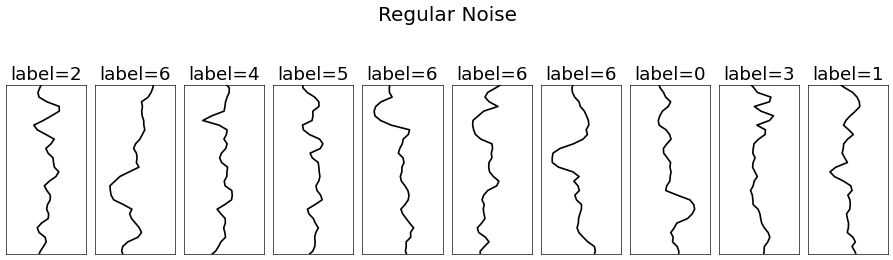

In [23]:
Plot = MNIST1D_Plot()

# Noisy Data
Plot.plot_signals(noisy_data['x'][:10], noisy_data['t'], labels=noisy_data['y'][:10], zoom = 5, title='Regular Noise')

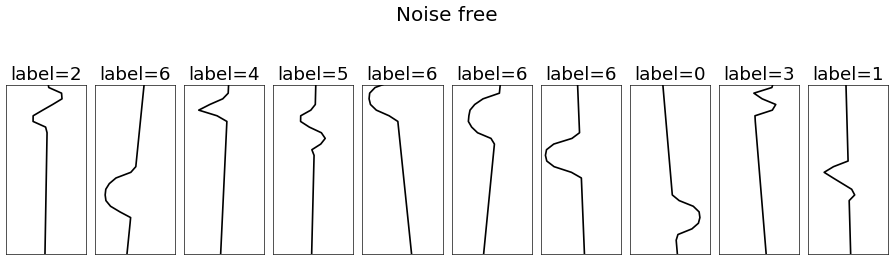

In [24]:
# Clean Data
Plot.plot_signals(clean_data['x'][:10], clean_data['t'], labels=clean_data['y'][:10], zoom = 5, title='Noise free')


In [25]:
class CNN(nn.Module):
    def __init__(self, channels=32):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=channels, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv1d(in_channels=channels, out_channels=channels, kernel_size=5 , stride=1, padding=2)
        self.conv3 = nn.Conv1d(in_channels=channels, out_channels=1, kernel_size=5, stride=1, padding=2)

    def count_params(self):
        return sum([p.view(-1).shape[0] for p in self.parameters()])

    def forward(self, x, verbose=False): # the print statements are for debugging
        h1 = self.conv1(x).relu()
        h2 = self.conv2(h1).relu()
        h3 = self.conv3(h2).relu()
        return h3
    

In [ ]:
class ConvNN(nn.Module):
    def __init__(self, channels=32):
        super(CNN, self).__init__()
        self.conv1 = Conv1d_NN(in_channels=1, out_channels=channels, kernel_size=5, stride=1, padding=2)
        self.conv2 = Conv1d_NN(in_channels=channels, out_channels=channels, kernel_size=5 , stride=1, padding=0)
        self.conv3 = Conv1d_NN(in_channels=channels, out_channels=1, kernel_size=5, stride=5, padding=0)

    def count_params(self):
        return sum([p.view(-1).shape[0] for p in self.parameters()])

    def forward(self, x, verbose=False): # the print statements are for debugging
        h1 = self.conv1(x).relu()
        h2 = self.conv2(h1).relu()
        h3 = self.conv3(h2).relu()
        return h3
    